<a href="https://colab.research.google.com/github/JoDeMiro/TimeSeriesLearn/blob/main/31_TSLearn_Distance_and_matrix_profile_on_Stock_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Distance and Matrix Profiles
This example illustrates how the matrix profile is calculated. For each
segment of a timeseries with a specified length, the distances between
each subsequence and that segment are calculated. The smallest distance is
returned, except for trivial match on the location where the segment is
extracted from which is equal to zero.


In [1]:
!pip install -q tslearn

     |████████████████████████████████| 793 kB 5.1 MB/s 


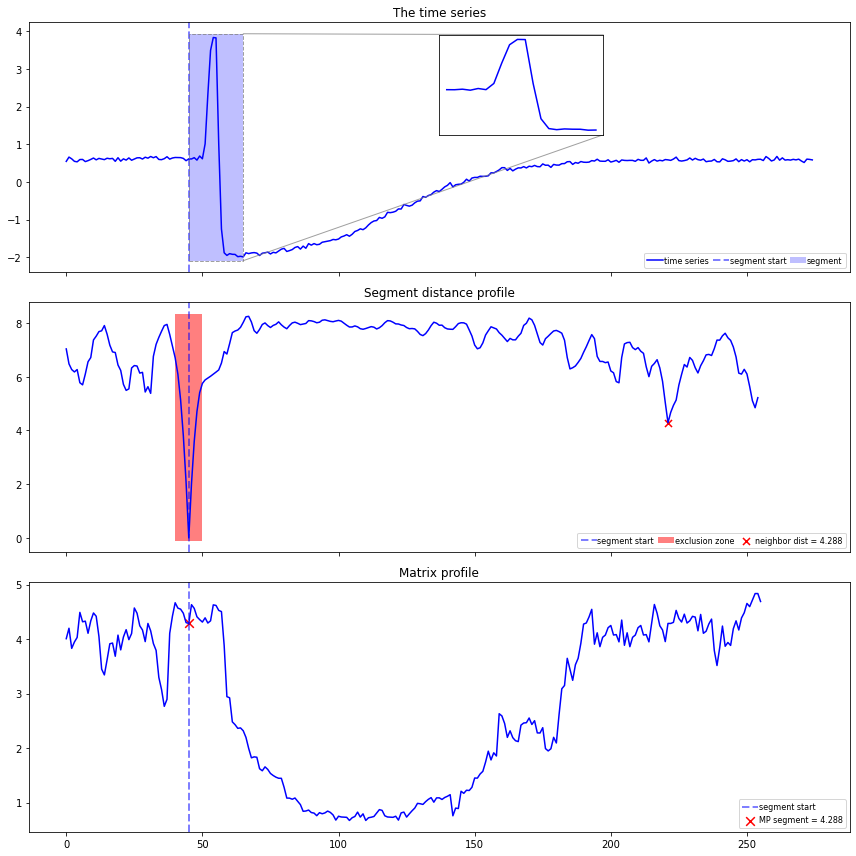

In [3]:
# Author: Gilles Vandewiele
# License: BSD 3 clause

import numpy
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.matrix_profile import MatrixProfile

import warnings
warnings.filterwarnings('ignore')

# Set a seed to ensure determinism
numpy.random.seed(42)

# Load the Trace dataset
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")

# Normalize the time series
scaler = TimeSeriesScalerMeanVariance()
X_train = scaler.fit_transform(X_train)

# Take the first time series
ts = X_train[0, :, :]

# We will take the spike as a segment
subseq_len = 20
start = 45
segment = ts[start:start + subseq_len]

# Create our matrix profile
matrix_profiler = MatrixProfile(subsequence_length=subseq_len, scale=True)
mp = matrix_profiler.fit_transform([ts]).flatten()

# Create a grid for our plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

# Plot our timeseries
ax1.plot(ts, c='b', label='time series')
ax1.add_patch(patches.Rectangle((start, numpy.min(ts) - 0.1), subseq_len,
                                numpy.max(ts) - numpy.min(ts) + 0.2,
                                facecolor='b', alpha=0.25,
                                label='segment'))
ax1.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax1.legend(loc='lower right', ncol=4, fontsize=8,
           handletextpad=0.1, columnspacing=0.5)
ax1.set_title('The time series')

# Inset plot with our segment
fig_ax_in = ax1.inset_axes([0.5, 0.55, 0.2, 0.4])
fig_ax_in.plot(scaler.fit_transform(segment.reshape(1, -1, 1))[0], c='b')
ax1.indicate_inset(inset_ax=fig_ax_in, transform=ax1.transData,
                   bounds=[start, numpy.min(ts) - 0.1, subseq_len,
                           numpy.max(ts) - numpy.min(ts) + 0.2],
                   linestyle='--', alpha=0.75)
fig_ax_in.tick_params(labelleft=False, labelbottom=False)
fig_ax_in.xaxis.set_visible(False)
fig_ax_in.yaxis.set_visible(False)

# Calculate a distance profile, which represents the distance from each
# subsequence of the time series and the segment
distances = []
for i in range(len(ts) - subseq_len):
    scaled_ts = scaler.fit_transform(ts[i:i+subseq_len].reshape(1, -1, 1))
    scaled_segment = scaler.fit_transform(segment.reshape(1, -1, 1))
    distances.append(numpy.linalg.norm(scaled_ts - scaled_segment))

# Mask out the distances in the trivial match zone, get the nearest
# neighbor and put the old distances back in place so we can plot them.
distances = numpy.array(distances)
mask = list(range(start - subseq_len // 4, start + subseq_len // 4))
old_distances = distances[mask]
distances[mask] = numpy.inf
nearest_neighbor = numpy.argmin(distances)
dist_nn = distances[nearest_neighbor]
distances[mask] = old_distances

# Plot our distance profile
ax2.plot(distances, c='b')
ax2.set_title('Segment distance profile')
dist_diff = numpy.max(distances) - numpy.min(distances)
ax2.add_patch(patches.Rectangle((start - subseq_len // 4,
                                 numpy.min(distances) - 0.1),
                                subseq_len // 2,
                                dist_diff + 0.2,
                                facecolor='r', alpha=0.5,
                                label='exclusion zone'))
ax2.scatter(nearest_neighbor, dist_nn, c='r', marker='x', s=50,
            label='neighbor dist = {}'.format(numpy.around(dist_nn, 3)))
ax2.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax2.legend(loc='lower right', fontsize=8, ncol=3,
           handletextpad=0.1, columnspacing=0.5)

# Plot our matrix profile
ax3.plot(mp, c='b')
ax3.set_title('Matrix profile')
ax3.scatter(start, mp[start],
            c='r', marker='x', s=75,
            label='MP segment = {}'.format(numpy.around(mp[start], 3)))
ax3.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax3.legend(loc='lower right', fontsize=8,
           handletextpad=0.1, columnspacing=0.25)

plt.tight_layout()
plt.show()

# Get Stock Data

In [ ]:
!pip install -q pandas-datareader --upgrade

In [1]:
import pandas_datareader as web
import pandas as pd

import pandas as pd
import pandas_datareader.data as web

In [37]:
from datetime import datetime

start = datetime(2014, 6, 2)
end = datetime(2020, 12, 20)

df = web.get_data_yahoo(['AAPL'],start=start,end=end)


In [38]:
df.columns

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Attributes', 'Symbols'])

In [39]:
df.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2014-06-02,20.113586,22.451786,22.672501,22.232143,22.641430,369350800.0
2014-06-03,20.398020,22.769285,22.812143,22.437500,22.445000,292709200.0
2014-06-04,20.630943,23.029285,23.138929,22.718214,22.765715,335482000.0
2014-06-05,20.711887,23.119642,23.191786,22.950357,23.078571,303805600.0
2014-06-06,20.654940,23.056070,23.259287,23.016787,23.210714,349938400.0


In [40]:
zaroar = df['Close']
type(zaroar)
aapl = zaroar.AAPL.values
type(aapl)

numpy.ndarray

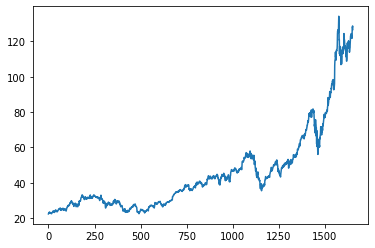

In [41]:
import matplotlib.pyplot as plt

plt.plot(aapl)
plt.show()

# Do the same

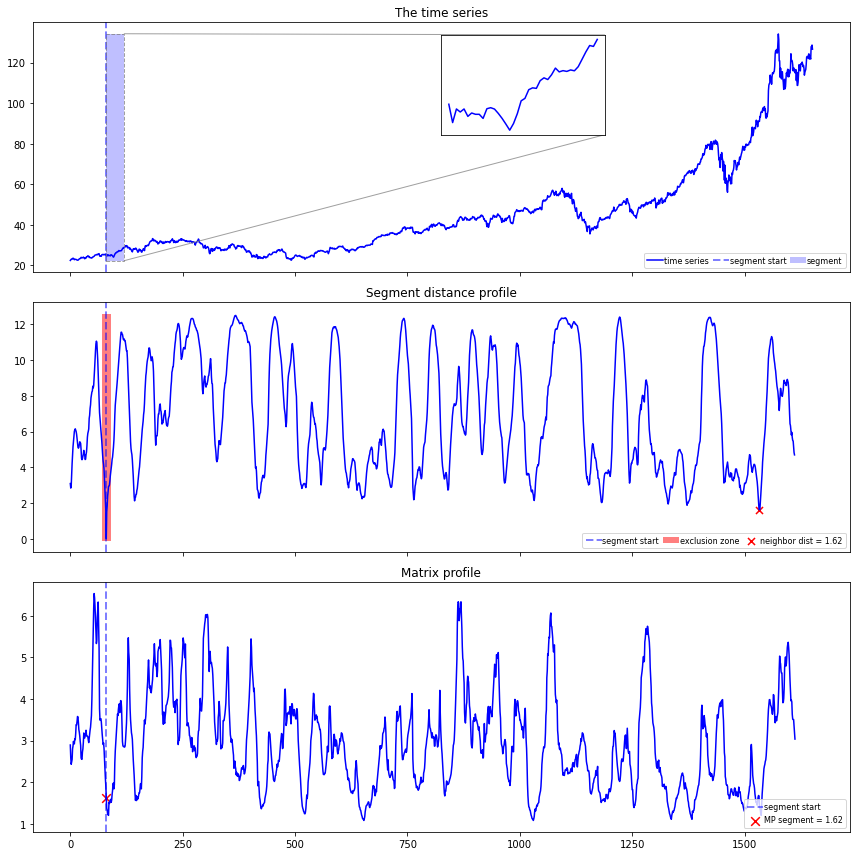

In [42]:
# Author: Gilles Vandewiele
# License: BSD 3 clause

import numpy
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.matrix_profile import MatrixProfile

import warnings
warnings.filterwarnings('ignore')

# Set a seed to ensure determinism
numpy.random.seed(42)

# Load the Trace dataset
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")


# Normalize the time series
scaler = TimeSeriesScalerMeanVariance()
X_train = scaler.fit_transform(X_train)

# Take the first time series
ts = X_train[0, :, :]

# Get our data
_idosor = aapl.copy()

# Reshape it
_idosor = _idosor.reshape(-1, 1)

# Assaigne it
ts = _idosor.copy()



# We will take the spike as a segment
subseq_len = 40
start = 80
segment = ts[start:start + subseq_len]

# Create our matrix profile
matrix_profiler = MatrixProfile(subsequence_length=subseq_len, scale=True)
mp = matrix_profiler.fit_transform([ts]).flatten()

# Create a grid for our plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

# Plot our timeseries
ax1.plot(ts, c='b', label='time series')
ax1.add_patch(patches.Rectangle((start, numpy.min(ts) - 0.1), subseq_len,
                                numpy.max(ts) - numpy.min(ts) + 0.2,
                                facecolor='b', alpha=0.25,
                                label='segment'))
ax1.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax1.legend(loc='lower right', ncol=4, fontsize=8,
           handletextpad=0.1, columnspacing=0.5)
ax1.set_title('The time series')

# Inset plot with our segment
fig_ax_in = ax1.inset_axes([0.5, 0.55, 0.2, 0.4])
fig_ax_in.plot(scaler.fit_transform(segment.reshape(1, -1, 1))[0], c='b')
ax1.indicate_inset(inset_ax=fig_ax_in, transform=ax1.transData,
                   bounds=[start, numpy.min(ts) - 0.1, subseq_len,
                           numpy.max(ts) - numpy.min(ts) + 0.2],
                   linestyle='--', alpha=0.75)
fig_ax_in.tick_params(labelleft=False, labelbottom=False)
fig_ax_in.xaxis.set_visible(False)
fig_ax_in.yaxis.set_visible(False)

# Calculate a distance profile, which represents the distance from each
# subsequence of the time series and the segment
distances = []
for i in range(len(ts) - subseq_len):
    scaled_ts = scaler.fit_transform(ts[i:i+subseq_len].reshape(1, -1, 1))
    scaled_segment = scaler.fit_transform(segment.reshape(1, -1, 1))
    distances.append(numpy.linalg.norm(scaled_ts - scaled_segment))

# Mask out the distances in the trivial match zone, get the nearest
# neighbor and put the old distances back in place so we can plot them.
distances = numpy.array(distances)
mask = list(range(start - subseq_len // 4, start + subseq_len // 4))
old_distances = distances[mask]
distances[mask] = numpy.inf
nearest_neighbor = numpy.argmin(distances)
dist_nn = distances[nearest_neighbor]
distances[mask] = old_distances

# Plot our distance profile
ax2.plot(distances, c='b')
ax2.set_title('Segment distance profile')
dist_diff = numpy.max(distances) - numpy.min(distances)
ax2.add_patch(patches.Rectangle((start - subseq_len // 4,
                                 numpy.min(distances) - 0.1),
                                subseq_len // 2,
                                dist_diff + 0.2,
                                facecolor='r', alpha=0.5,
                                label='exclusion zone'))
ax2.scatter(nearest_neighbor, dist_nn, c='r', marker='x', s=50,
            label='neighbor dist = {}'.format(numpy.around(dist_nn, 3)))
ax2.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax2.legend(loc='lower right', fontsize=8, ncol=3,
           handletextpad=0.1, columnspacing=0.5)

# Plot our matrix profile
ax3.plot(mp, c='b')
ax3.set_title('Matrix profile')
ax3.scatter(start, mp[start],
            c='r', marker='x', s=75,
            label='MP segment = {}'.format(numpy.around(mp[start], 3)))
ax3.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax3.legend(loc='lower right', fontsize=8,
           handletextpad=0.1, columnspacing=0.25)

plt.tight_layout()
plt.show()

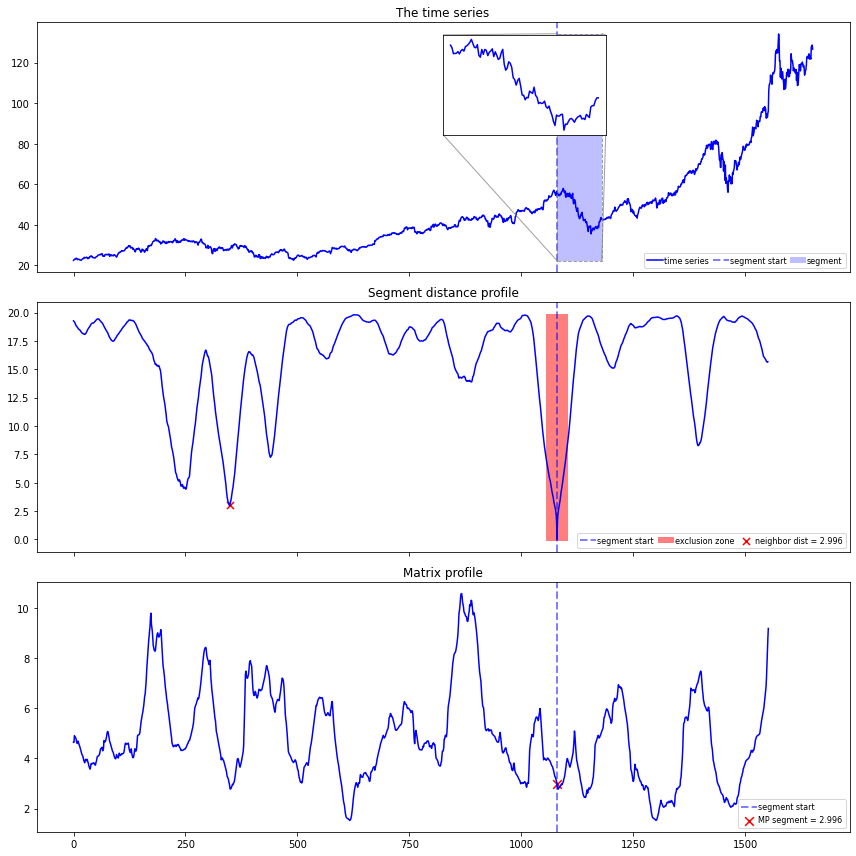

In [47]:

# Set a seed to ensure determinism
numpy.random.seed(42)

# We will take the spike as a segment
subseq_len = 100
start = 1080
segment = ts[start:start + subseq_len]

# Create our matrix profile
matrix_profiler = MatrixProfile(subsequence_length=subseq_len, scale=True)
mp = matrix_profiler.fit_transform([ts]).flatten()

# Create a grid for our plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

# Plot our timeseries
ax1.plot(ts, c='b', label='time series')
ax1.add_patch(patches.Rectangle((start, numpy.min(ts) - 0.1), subseq_len,
                                numpy.max(ts) - numpy.min(ts) + 0.2,
                                facecolor='b', alpha=0.25,
                                label='segment'))
ax1.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax1.legend(loc='lower right', ncol=4, fontsize=8,
           handletextpad=0.1, columnspacing=0.5)
ax1.set_title('The time series')

# Inset plot with our segment
fig_ax_in = ax1.inset_axes([0.5, 0.55, 0.2, 0.4])
fig_ax_in.plot(scaler.fit_transform(segment.reshape(1, -1, 1))[0], c='b')
ax1.indicate_inset(inset_ax=fig_ax_in, transform=ax1.transData,
                   bounds=[start, numpy.min(ts) - 0.1, subseq_len,
                           numpy.max(ts) - numpy.min(ts) + 0.2],
                   linestyle='--', alpha=0.75)
fig_ax_in.tick_params(labelleft=False, labelbottom=False)
fig_ax_in.xaxis.set_visible(False)
fig_ax_in.yaxis.set_visible(False)

# Calculate a distance profile, which represents the distance from each
# subsequence of the time series and the segment
distances = []
for i in range(len(ts) - subseq_len):
    scaled_ts = scaler.fit_transform(ts[i:i+subseq_len].reshape(1, -1, 1))
    scaled_segment = scaler.fit_transform(segment.reshape(1, -1, 1))
    distances.append(numpy.linalg.norm(scaled_ts - scaled_segment))

# Mask out the distances in the trivial match zone, get the nearest
# neighbor and put the old distances back in place so we can plot them.
distances = numpy.array(distances)
mask = list(range(start - subseq_len // 4, start + subseq_len // 4))
old_distances = distances[mask]
distances[mask] = numpy.inf
nearest_neighbor = numpy.argmin(distances)
dist_nn = distances[nearest_neighbor]
distances[mask] = old_distances

# Plot our distance profile
ax2.plot(distances, c='b')
ax2.set_title('Segment distance profile')
dist_diff = numpy.max(distances) - numpy.min(distances)
ax2.add_patch(patches.Rectangle((start - subseq_len // 4,
                                 numpy.min(distances) - 0.1),
                                subseq_len // 2,
                                dist_diff + 0.2,
                                facecolor='r', alpha=0.5,
                                label='exclusion zone'))
ax2.scatter(nearest_neighbor, dist_nn, c='r', marker='x', s=50,
            label='neighbor dist = {}'.format(numpy.around(dist_nn, 3)))
ax2.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax2.legend(loc='lower right', fontsize=8, ncol=3,
           handletextpad=0.1, columnspacing=0.5)

# Plot our matrix profile
ax3.plot(mp, c='b')
ax3.set_title('Matrix profile')
ax3.scatter(start, mp[start],
            c='r', marker='x', s=75,
            label='MP segment = {}'.format(numpy.around(mp[start], 3)))
ax3.axvline(start, c='b', linestyle='--', lw=2, alpha=0.5,
            label='segment start')
ax3.legend(loc='lower right', fontsize=8,
           handletextpad=0.1, columnspacing=0.25)

plt.tight_layout()
plt.show()